<a href="https://colab.research.google.com/github/audibagja/eaaabagja/blob/master/lstm_terbaru.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
#Import the libraries
from datetime import datetime
import requests
import math
import io
import pandas_datareader as pdr
import numpy as np
import pandas 
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import Dense, LSTM
import matplotlib.pyplot as plt
plt.style.use('fivethirtyeight')

class YahooData:
  def fetch(ticker, start, end):
    headers = {
        'User-Agent': 'Mozilla/5.0 (Macintosh; Intel Mac OS X 10_11_2) AppleWebKit/601.3.9 (KHTML, like Gecko) Version/9.0.2 Safari/601.3.9'
    }

    url = "https://query1.finance.yahoo.com/v7/finance/download/" + str(ticker)
    x = int(datetime.strptime(start, '%Y-%m-%d').strftime("%s"))
    y = int(datetime.strptime(end, '%Y-%m-%d').strftime("%s"))
    url += "?period1=" + str(x) + "&period2=" + str(y) + "&interval=1d&events=history&includeAdjustedClose=true"
    
    r = requests.get(url, headers=headers)
    pd = pandas.read_csv(io.StringIO(r.text), index_col=0, parse_dates=True)

    return pd


In [ ]:
df = YahooData.fetch("PFE", start='2012-01-01', end='2020-12-17')
print(df)

                 Open       High        Low      Close  Adj Close    Volume
Date                                                                       
2012-01-03  20.740038  20.872866  20.721064  20.844402  14.607581  53124340
2012-01-04  20.796965  20.825426  20.635674  20.654650  14.474593  31912485
2012-01-05  20.607210  20.607210  20.294119  20.493359  14.361571  52764821
2012-01-06  20.607210  20.664137  20.455408  20.464895  14.341620  31613571
2012-01-09  20.455408  20.721064  20.407970  20.702087  14.507843  41786041
...               ...        ...        ...        ...        ...       ...
2020-12-10  41.820000  42.220001  41.450001  41.730000  40.511208  57749200
2020-12-11  41.970001  42.070000  40.689999  41.119999  39.919025  60737000
2020-12-14  41.619999  41.660000  39.070000  39.209999  38.064808  94809700
2020-12-15  39.060001  39.180000  38.209999  38.709999  37.579411  65712800
2020-12-16  38.180000  38.470001  37.740002  37.840000  36.734825  56515300

[2255 rows 

In [ ]:
df.shape

(2255, 6)

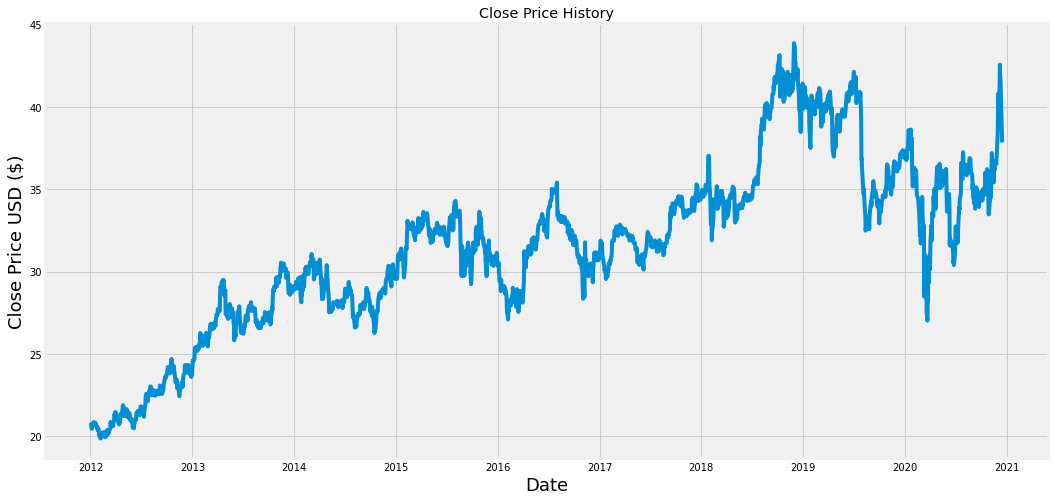

In [ ]:
#Visualize the closing price history
plt.figure(figsize=(16,8))
plt.title('Close Price History')
plt.plot(df['Close'])
plt.xlabel('Date',fontsize=18)
plt.ylabel('Close Price USD ($)',fontsize=18)
plt.show()

In [ ]:
#Create a new dataframe with only the 'Close' column
data = df.filter(['Close'])
#Converting the dataframe to a numpy array
dataset = data.values
#Get /Compute the number of rows to train the model on
training_data_len = math.ceil( len(dataset) *.8) 

In [ ]:
#Scale the all of the data to be values between 0 and 1 
scaler = MinMaxScaler(feature_range=(0,1)) 
scaled_data = scaler.fit_transform(dataset)
scaled_data

array([[0.04034814],
       [0.03243681],
       [0.02571209],
       ...,
       [0.8060656 ],
       [0.78521909],
       [0.74894619]])

In [ ]:
#Create the scaled training data set 
train_data = scaled_data[0:training_data_len  , : ]
#Split the data into x_train and y_train data sets
x_train=[]
y_train = []
for i in range(60,len(train_data)):
    x_train.append(train_data[i-60:i,0])
    y_train.append(train_data[i,0])


In [ ]:
#Convert x_train and y_train to numpy arrays
x_train, y_train = np.array(x_train), np.array(y_train)

In [ ]:
#Reshape the data into the shape accepted by the LSTM
x_train = np.reshape(x_train, (x_train.shape[0],x_train.shape[1],1))

In [ ]:
#Build the LSTM network model
model = Sequential()
model.add(LSTM(units=128, return_sequences=True,input_shape=(x_train.shape[1],1)))
model.add(LSTM(units=64, return_sequences=False))
model.add(Dense(units=25))
model.add(Dense(units=1))

In [ ]:
#Compile the model
model.compile(optimizer='adam', loss='mean_squared_error')

In [ ]:
#Train the model
model.fit(x_train, y_train, batch_size=1, epochs=1)

1744/1744 [==============================] - 83s 35ms/step - loss: 0.0031


In [ ]:
#Test data set
test_data = scaled_data[training_data_len - 60: , : ]
#Create the x_test and y_test data sets
x_test = []
y_test =  dataset[training_data_len : , : ] #Get all of the rows from index 1603 to the rest and all of the columns (in this case it's only column 'Close'), so 2003 - 1603 = 400 rows of data
for i in range(60,len(test_data)):
    x_test.append(test_data[i-60:i,0])

In [ ]:
#Convert x_test to a numpy array 
x_test = np.array(x_test)

In [ ]:
#Reshape the data into the shape accepted by the LSTM
x_test = np.reshape(x_test, (x_test.shape[0],x_test.shape[1],1))

In [ ]:
#Getting the models predicted price values
predictions = model.predict(x_test) 
predictions = scaler.inverse_transform(predictions)#Undo scaling

In [ ]:
#Calculate/Get the value of RMSE
rmsey=np.sqrt(np.mean(((predictions- y_test)**2)))
rmsey


0.9231481642432677

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """


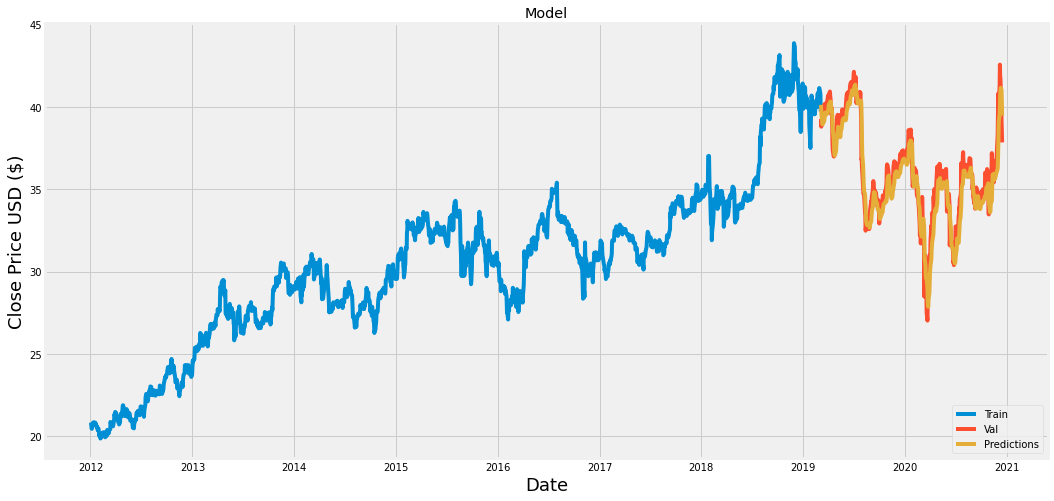

In [ ]:

#Plot/Create the data for the graph
train = data[:training_data_len]
valid = data[training_data_len:]
valid['Predictions'] = predictions
#Visualize the data
plt.figure(figsize=(16,8))
plt.title('Model')
plt.xlabel('Date', fontsize=18)
plt.ylabel('Close Price USD ($)', fontsize=18)
plt.plot(train['Close'])
plt.plot(valid[['Close', 'Predictions']])
plt.legend(['Train', 'Val', 'Predictions'], loc='lower right')
plt.show()

In [ ]:
#Show the valid and predicted prices
valid.tail(50)

,Close,Predictions
Date,,
2020-10-07,34.601517,34.204407
2020-10-08,35.000000,34.188465
2020-10-09,34.905125,34.285282
2020-10-12,34.933586,34.371250
2020-10-13,35.009487,34.439632
2020-10-14,34.971539,34.502697
2020-10-15,34.677418,34.536930
2020-10-16,36.005692,34.477314
2020-10-19,35.863377,34.736382


In [ ]:
#Get the quote
apple_quote = pdr.DataReader('PFE', data_source='yahoo', start='2012-01-01', end='2020-12-17')
#Create a new dataframe
new_df = apple_quote.filter(['Close'])
#Get teh last 60 day closing price 
last_60_days = new_df[-60:].values
#Scale the data to be values between 0 and 1
last_60_days_scaled = scaler.transform(last_60_days)
#Create an empty list
X_test = []
#Append teh past 60 days
X_test.append(last_60_days_scaled)
#Convert the X_test data set to a numpy array
X_test = np.array(X_test)
#Reshape the data
X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))
#Get the predicted scaled price
pred_price = model.predict(X_test)
#undo the scaling 
pred_price = scaler.inverse_transform(pred_price)
print(pred_price)

RemoteDataError: ignored